# Introduction to PyTorch

<span style="font-size:1.5em; color:blue">
 In this section, we will cover some essential concepts of PyTorch.
</span>

* <span style="font-size:1.25em">Tensors</span>
* <span style="font-size:1.25em">Autograd</span>
* <span style="font-size:1.25em">Layers</span>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import torch

## PyTorch Tensors

<span style="font-size:1.5em; color:blue">
Tensors are the main computational data structure suitable for many scientific computations.  
They are N-dimensional arrays that represent highly structured data with many pre-defined operations, e.g. matices.  
They can be easily transferred across computing devices (GPUs) in order to accelerate the computation. <br/><br/> 
Next, we'll give some quick examples to demonstrate these advantages of tensors.
</span>

### Create some ramdom vectors

<span style="font-size:1.5em; color:blue">
Below, we create two vectors and sample values from a uniform distribution.
</span>

In [2]:
x = torch.empty(300).uniform_(-1,1)
y = torch.empty(300).uniform_(-1,1)

### Run some simple calculation like the covariance

<span style="font-size:1.5em; color:blue">
Here you can see the common multi-dimentional array arithmetics happening, such as:
</span>

* <span style="font-size:1.25em">Broadcasting between `x` and `x.mean()`</span>
* <span style="font-size:1.25em">Dot product</span>
    * <span style="font-size:1.25em">Type conversion</span>

> Note that the computation will be carried out using `tensor` as the data structure.
> That's why you should see tensor(.) as a result.

In [3]:
torch.dot(x - x.mean(), y - y.mean()) / x.shape[0]

tensor(0.0148)

### Let's create a sample dataset to play with

<span style="font-size:1.5em; color:blue">If we view the two vectors as values from the 2 axes of a 2-D coordinate system as shown below and label the data points based on their signs, we can generate the famous XOR dataset to experiment with.
</span>

> Notice how we used `.numpy()` to convert the tensors into numpy arrays, which are also multi-dimensional arrays but they can be operated on CPUs only.  
> Similarly, if we want to transfer a tensor to GPU, we could use the method `.cuda()`.

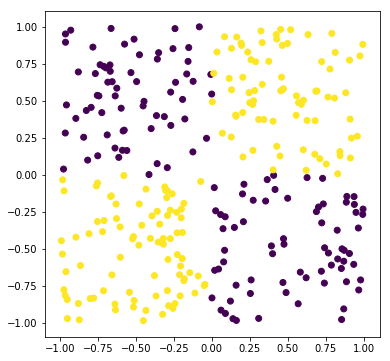

In [4]:
d = x*y>=0
plt.figure(figsize=(6,6))
plt.scatter(x.numpy(), y.numpy(), c=d.numpy())

## Artificial Neuron & Autograd

<span style="font-size:1.5em; color:blue">
It is an elementary mathematical component in artificial neural networks, 
that can be trained to create a model suitable for some specific problem and training data. 
The learned knowledge is stored as weights $w$ and bias $b$. 
The input data is transformed using a linear combination and some nonlinear function known as the activation $\varphi$.
</span>

$$
y = \varphi(w^T x+b)
$$

<span style="font-size:1.5em; color:blue">
Neural networks are typically built by stacking up layers of neurons that defines the mathetical model,
which learn from training data using an optimization algorithm.
This training procedure usually involves the following key steps:
</span>

1. Fordward pass: passing the training data forward through the network to get some prediction
2. Compute error: a criterion (aka loss function) is then applied to compare the prediction against training labels
3. Compute gradient: computing a plausible direction towards which the model may get better prediction i.e. minize the error
4. Update parameters: changing model parameters, include weights and biases based on the gradient (and some other factors depending on the optimization algorithm)

<span style="font-size:1.5em; color:blue">
Next, we demonstrate how this is done with PyTorch on a microscopic level with one neuron.
</span>

> `requires_grad=True` enables autograd for a tensor variable.  
> In `y.reshape(-1, 1)`, -1 means any.

In [5]:
# Set up a neuron with sigmoid activation and mean squared error loss.
X = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1)),1)
w = torch.randn(2, requires_grad=True)

# Forward pass
y_pred = 1/(1+torch.exp(-w.dot(X[0])))

# Compute error
loss = (d[0] - y_pred).pow(2)

# Backward pass
loss.backward()

# Here's the gradient of the weights wrt loss.
print(f"""Autograd => {w.grad}
Chain Rule => {2 * (d[0] - y_pred) * (-1) * y_pred * (1-y_pred) * X[0]}""")

Autograd => tensor([-0.0334,  0.1890])
Chain Rule => tensor([-0.0334,  0.1890], grad_fn=<MulBackward0>)


## Dense Neuron Layer

<span style="font-size:1.5em; color:blue">
The most simple way to create an artificial neural network is fully connect neurons between layers, which creates a perceptron model.
With the understanding of how tensors and autograd work in PyTorch, let's create a simple neural network, with the help of the NN layers that PyTorch provides (specifically `torch.nn.Linear` and `torch.nn.ReLU`), to solve the XOR dataset that we have constructed earlier.
</span>

<span style="font-size:1.5em; color:blue">
(A visualization of this model: [click here](http://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.1&regularizationRate=0&noise=0&networkShape=3,2&seed=0.39975&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false))
</span>

In [6]:
class XORNet(torch.nn.Module):
    def __init__(self):
        super(XORNet, self).__init__()
        self.hidden2 = torch.nn.Linear(2, 3, bias=False)
        self.hidden2.weight.data = torch.Tensor([[2,0],[0,-2],[2,-2]]) # <= How to preload weights
        self.hidden2.weight.requires_grad = False                      # <= How to lock weights
        self.act2 = torch.nn.ReLU()
        self.hidden1 = torch.nn.Linear(3, 2)
        self.act1 = torch.nn.ReLU()
        self.out = torch.nn.Linear(2, 1)
        self.act0 = torch.nn.ReLU()

    def forward(self, x):
        x = self.act2(self.hidden2(x))
        x = self.act1(self.hidden1(x))
        x = self.act0(self.out(x))
        return x

### Training loop

<span style="font-size:1.5em; color:blue">
We will use the first 3/4 of the samples as training set and the last 1/4 of the samples as the testing set.
</span>

> Your results may vary. You may run the following cell many times.  
> Due to the small amount of sample data, this training loop does not show batching, but uses the entire train/test subset.

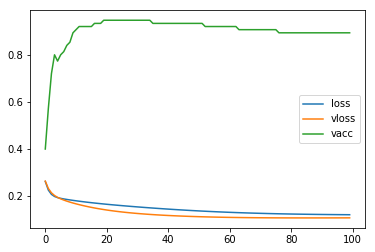

In [7]:
model = XORNet()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

loss_history = []  # Training loss
vloss_history = [] # Validation loss
vacc_history = []  # Validation accuracy

EPOCHS = 100
NUM_TRAIN = X.shape[0] // 4 * 3
NUM_TEST = X.shape[0] - NUM_TRAIN

for _ in range(EPOCHS):
    model.train()
    with torch.set_grad_enabled(True):
        # Forward pass
        y_pred = model(X[:NUM_TRAIN])

        # Compute error
        loss = (y_pred - d[:NUM_TRAIN].reshape(-1, 1).float()).pow(2).sum() / NUM_TRAIN

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
    
        # Update weights
        optimizer.step()
        
        loss_history.append(loss.item())
    
    model.eval()
    with torch.set_grad_enabled(False):
        y_pred = model(X[NUM_TRAIN:])
        vloss = y_pred - d[NUM_TRAIN:].reshape(-1, 1).float()
        acc = torch.sum((torch.abs(vloss)<0.5).float()) / NUM_TEST
        vloss = vloss.pow(2).sum() / NUM_TEST
        vloss_history.append(vloss.item())
        vacc_history.append(acc.item())

plt.plot(list(range(EPOCHS)), loss_history, label='loss')
plt.plot(list(range(EPOCHS)), vloss_history, label='vloss')
plt.plot(list(range(EPOCHS)), vacc_history, label='vacc')
plt.legend()

# Congrats, Part 1 complete!